# Get a better understanding of "Parity Flips" in the lattice

Started with the Proof Support notebook

In [100]:
import sys, io
import math
import numpy as np
import pandas as pd
from scipy.optimize import nnls
from fractions import Fraction
from sympy import factorint
from itertools import product
from typing import List, Optional, Tuple
import random


In [101]:
def C(n):
    """ Compute next value in simplified Collatz sequence.
    """
    if n & 1 == 0:
        return n//2
    else:
        return (3*n + 1)//2
#
def L_C(n):
    """ Compute binary label-string for a given Collatz number
    """
    if n == 1:
        return "1"

    S = ""
    while n != 1:
        if n & 1 == 0:
            n = n//2
            S = S + "1"
        else:
            n = (3*n + 1)//2
            S = S + "0"
    return S
#
def collatzVector(collatzNumber):
    chain = [collatzNumber]
    while collatzNumber != 1:
        if (collatzNumber & 1) == 0:
            collatzNumber = collatzNumber // 2
        else:
            collatzNumber = (3 * collatzNumber + 1) // 2
        chain.append(collatzNumber)
    chain.append(chain[-2])
    return np.array(chain)
    
def collatzPath(collatzNumber):
    path = []
    while collatzNumber != 1:
        if (collatzNumber & 1) == 0:
            collatzNumber = collatzNumber // 2
            path.append("1")
        else:
            collatzNumber = (3 * collatzNumber + 1) // 2
            path.append("0")
    return "".join(path)
#

In [102]:
def Ay_L(L):
    """ Generate A matrix and y vector from label string
    """
    rank = len(L) + 2    
    A = np.zeros((rank,rank))
    y = np.zeros((rank))
    for row in range(rank-3):
        if L[row] == "1":
            a_val = -1.0
            y_val = 0.0
        else:
            a_val = -3.0
            y_val = 1.0
        A[row][row] = a_val
        A[row][row+1] = 2.0
        y[row] = y_val
    #
    # Last 3 rows are always the same
    row = rank - 3
    A[row][row] = -1
    A[row][row+1] = 2
    y[row] = 0
    row = rank - 2
    A[row][row] = -3
    A[row][row+1] = 2
    y[row] = 1
    row = rank - 1
    A[row][row] = -1
    A[row][row-2] = 1
    y[row] = 0
    
    return A, y
#

In [103]:
Ay_L("00111")

(array([[-3.,  2.,  0.,  0.,  0.,  0.,  0.],
        [ 0., -3.,  2.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -1.,  2.,  0.,  0.,  0.],
        [ 0.,  0.,  0., -1.,  2.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  2.,  0.],
        [ 0.,  0.,  0.,  0.,  0., -3.,  2.],
        [ 0.,  0.,  0.,  0.,  1.,  0., -1.]]),
 array([1., 1., 0., 0., 0., 1., 0.]))

In [104]:
def solve_Ay_L(L):
    """ Solve for the x vector given the label-string
    """
    A, y = Ay_L(L)
    return A, np.linalg.solve(A, y), y
#

In [105]:
solve_Ay_L("00111")

(array([[-3.,  2.,  0.,  0.,  0.,  0.,  0.],
        [ 0., -3.,  2.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -1.,  2.,  0.,  0.,  0.],
        [ 0.,  0.,  0., -1.,  2.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  2.,  0.],
        [ 0.,  0.,  0.,  0.,  0., -3.,  2.],
        [ 0.,  0.,  0.,  0.,  1.,  0., -1.]]),
 array([3., 5., 8., 4., 2., 1., 2.]),
 array([1., 1., 0., 0., 0., 1., 0.]))

In [106]:
def x0_L(L):
    """ Get the x[0] value given a label-string
    """
    A, x, y = solve_Ay_L(L)
    return round(x[0])  # clean up mantisa garbage
#

In [107]:
x0_L("00111")

3

In [108]:
def countZeros(label):
    zero_count = 0
    for bit in label:
        if bit == "0":
            zero_count += 1
    return zero_count
#

def Z(L):
    """ Indexes of zeros in label string
    """
    for i in range(len(L)):
        if L[i] == "0":
            yield i
#

In [109]:
list(Z("00111"))

[0, 1]

In [110]:
def a_b_c_S(L):
    """ Get the (power-of-two, power-of-three, zero-sum-accumulator) tuple for a node given its label
    """
    a = len(L)
    b = 0
    for bit in L:
        if bit == "0":
            b += 1
    ZZ = [(j,i) for j, i in enumerate(Z(L))]
    c = sum((3 ** (b - j - 1)) * (2 ** (i)) for j, i in ZZ)
    S = [zz[1] for zz in ZZ]
    return (a,b,c,S)

In [111]:
a_b_c_S("01")

(2, 1, 1, [0])

In [112]:
a_b_c_S("00111")

(5, 2, 5, [0, 1])

In [113]:
def val_a_b_c(a_b_c):
    """ Get the value for a node given the tuple (power-of-two, power-of-three, zero-sum-accumulator)
    """
    a, b, c = a_b_c
    f = Fraction( ((2**a) - c), (3**b) )
    return (f.numerator, f.denominator)
#
def val_a_b_c_S(a_b_c_S):
    a_b_c = (a_b_c_S[0], a_b_c_S[1], a_b_c_S[2])
    return val_a_b_c(a_b_c)
#

In [114]:
val_a_b_c((5, 2, 5))

(3, 1)

In [115]:
def val_L(L):
    """ Get the value for a node given the label string
    """
    return val_a_b_c_S(a_b_c_S(L))
#

In [116]:
val_L("00111")

(3, 1)

In [117]:
N_i = ((0,0), [])

In [118]:
def mr_TupItemValue(a_b, a_0):
    """ Value of (a, b) tuple with a_0 added to b so we are not dealing with float limitations
    """
    a,b = a_b
    return (2**a)*(3**(a_0 + b))
#
def mrTupValue(mr_tup):
    """ Compute the value of the given mrTup

        Returns value as a cannonical (numerator, denominator) pair
    """
    # Multiplying the numerator by 3 ** the generation keeps us in integer land
    a_0 = mr_tup[0][0]
    total = mr_TupItemValue(mr_tup[0], a_0)
    for a_b in mr_tup[1]:
        total -= mr_TupItemValue(a_b, a_0)
    frac = Fraction(total, 3**a_0)
    return (frac.numerator, frac.denominator)
#

In [119]:
mrTupValue(N_i)

(1, 1)

In [120]:
def F_0(mr_tup):
    u_tup, v_list = mr_tup
    a,b = u_tup
    u_tup_ = (a+1, b-1)
    if len(v_list) > 0:
        b_ = v_list[-1][1] - 1
    else:
        b_ = b - 1
    v_list = [(vt[0], vt[1]) for vt in v_list] + [(a, b_ )]
    return (u_tup_, v_list)
#

In [121]:
# Terse version for math conversion
def F_0(mr_tup):
    return ( (mr_tup[0][0]+1, mr_tup[0][1]-1), mr_tup[1] + [(mr_tup[0][0], mr_tup[0][1]-1)] )
#

In [122]:
def F_1(mr_tup):
    u_tup, v_list = mr_tup
    a,b = u_tup
    u_tup = (a+1, b)
    return (u_tup, v_list)
#

In [123]:
def F_1(mr_tup):
    return ((mr_tup[0][0]+1, mr_tup[0][1]), mr_tup[1])
#

In [124]:
mrTupValue(F_1(N_i))

(2, 1)

In [125]:
F_0(N_i)

((1, -1), [(0, -1)])

In [126]:
mrTupValue(F_0(N_i))

(1, 3)

In [127]:
mrTupValue(F_0(F_0(N_i)))

(-1, 9)

In [128]:
F_0(F_0(N_i))
# 4/9 - 1/9 -2/3

((2, -2), [(0, -1), (1, -2)])

In [129]:
mrTupValue(F_0(F_0(N_i)))

(-1, 9)

In [130]:
mrTupValue(F_0(F_0(F_0(N_i))))

(-11, 27)

In [131]:
mrTupValue(F_0(F_0(F_1(N_i))))

(-2, 9)

In [132]:
def F_rev(mr_tup):
    """ Reverse of either F0 or F1, uses contents of L list to determine COA
    """
    u_tup, v_list = mr_tup
    a,b = u_tup
    a_ = a-1
    b_ = b
    if len(v_list) > 0:
        if v_list[-1][0] == a_:
            b_ = b+1
            if len(v_list) > 1:
                v_list =  [(vt[0], vt[1]) for vt in v_list[0:-1]]
            else:
                v_list = []
    return ((a_, b_), v_list)
#
    

In [133]:
F_rev(F_rev(F_0(F_0(N_i))))

((0, 0), [])

In [134]:
F_rev(F_rev(F_1(F_1(N_i))))

((0, 0), [])

In [137]:
def mrTupFromPath(label):
    """ Create an mrTup given a path (label)
    """
    mr_tup = N_i
    for bit in label:
        if bit == "1":
            mr_tup = F_1(mr_tup)
        else:
            mr_tup = F_0(mr_tup)
    return mr_tup
#
def mrTupFromValue(n):
    label = collatzPath(n)
    return mrTupFromPath(label)
#
def mrTupToLaTex(T):
    a, b = T[0]
    s = "\\frac{2^{%d}}{3^{%d}}"%(a, -b)
    L = T[1]
    if len(L) > 0:
        s = s + " - ( "
        plus = "  "
        for c_d in L:
            c, d = c_d
            t = "\\frac{2^{%d}}{3^{%d}}"%(c, -d)
            s = s + plus + t
            plus = " + "
        s = s + " )"
    return "$ " + s + " $"
#

In [138]:
mrTupFromPath(collatzPath(7))

((11, -5), [(0, -1), (1, -2), (2, -3), (4, -4), (7, -5)])

In [139]:
# 27 has the longest Collatz path for a number less < 32
mrTupFromPath(collatzPath(27))

((70, -41),
 [(0, -1),
  (1, -2),
  (3, -3),
  (4, -4),
  (5, -5),
  (6, -6),
  (7, -7),
  (9, -8),
  (11, -9),
  (12, -10),
  (14, -11),
  (15, -12),
  (16, -13),
  (18, -14),
  (19, -15),
  (20, -16),
  (21, -17),
  (23, -18),
  (26, -19),
  (27, -20),
  (28, -21),
  (30, -22),
  (31, -23),
  (33, -24),
  (34, -25),
  (35, -26),
  (36, -27),
  (37, -28),
  (38, -29),
  (41, -30),
  (42, -31),
  (43, -32),
  (44, -33),
  (48, -34),
  (50, -35),
  (52, -36),
  (56, -37),
  (59, -38),
  (60, -39),
  (61, -40),
  (66, -41)])

In [140]:
mrTupValue(mrTupFromPath(collatzPath(27)))

(27, 1)

In [141]:
def rationalCollatzPath(fraction_tup, max_length=100):
    """ Apply Collatz rules to a rational to see if it has a path to 1 and is in the lattice 
    """
    numerator_0, denominator_0 = fraction_tup
    rational_collatz_path = [(numerator_0, denominator_0)]
    numerator, denominator = fraction_tup
    for i in range(max_length):
        if numerator == 1 and denominator == 1:
            break
        if (abs(numerator) & 1) == 1:
            numerator = 3*numerator + denominator
        denominator = 2*denominator
        f = Fraction(numerator, denominator)
        numerator = f.numerator
        denominator = f.denominator
        # Check for a cycle
        if (numerator, denominator) in rational_collatz_path:
            rational_collatz_path.append((numerator, denominator))
            break
        rational_collatz_path.append((numerator, denominator))

    return rational_collatz_path

In [142]:
rationalCollatzPath((5,7))

[(5, 7), (11, 7), (20, 7), (10, 7), (5, 7)]

In [143]:
def gen_generation(a):
    """ Generate a (label, a_b_c_tuple, numerator_denominator_pair) tuple for each
        lattice node in a generation

        Note: uses what we have learned regarding the mapping of the label string
        to create a nodes L subtractand list -- does not require applying F_0, F_1

        Fastest way to generate a generation's nodes
    """
    seqs = product('10', repeat=a)
    for bits in seqs:
        label = ''.join(bits)
        zeros = [i for i, b in enumerate(bits) if b == '0']
        b = len(zeros)
        # compute c = sum_{j=0}^{k} 3^{k-j} * 2^{i_j - 1}
        c = sum((3 ** (b - j - 1)) * (2 ** (i)) for j, i in enumerate(zeros))
        f = Fraction(2**a - c, 3**b)
        yield (label, (a,b,c), (f.numerator, f.denominator))
#

In [144]:
def T_010_to_T_111(k):  # 1(mod 8)
    return 9*k + 7
#
def T_010_to_T_110(k):
    return 3*k + 1
#
def T_010_to_T_011(k):
    return 3*k + 2
#
def T_101_to_T_111(k):
    return 3*k + 2
#
def T_001_to_T_111(k): # 3(mod 8)
    return 9*k + 5
#
def T_001_to_T_101(k):
    return 3*k + 1
#
def T_110_to_T_111(k):
    return 3*k + 4
#
def T_110_to_T_011(k):
    return k + 1
#
def T_011_to_T_111(k): # 5(mod 8)
    return 3*k + 1
#
def T_011_to_T_110(k):
    return k - 1
#
def T_011_to_T_100(k):
    # Not affine at 3 bits ...
    if (k%24) == 21:
        return (k//3) -1
    else:
        return k+2
#
def T_100_to_T_111(k):
    return 9*k + 10
#
def T_100_to_T_110(k):
    return 3*k + 2
#
def T_100_to_T_011(k):
    return 3*k + 3
#
def T_000_to_T_111(k):  # 7 (mod 8)
    return 27*k + 19
#
def T_000_to_T_110(k):
    return 9*k + 5
#
def T_000_to_T_011(k):
    return 9*k + 6
#
def T_000_to_T_100(k):
    return 3*k + 1
#

def checkMod8Formula(mod_8, tranform_func, prefix):
    for i in range(1000):
        k = 8*(i+2) + mod_8
        label = collatzPath(k)
        label_ = prefix + label[len(prefix):]
        val_ = mrTupValue(mrTupFromPath(label_))
        if val_[1] != 1:
            print(f"Label substitution FAILED {k}({label}) -> ({label_}) has noninteger {val_}")
            return False
        k_ = tranform_func(k) 
        if k_ != val_[0]:
            print(f"{tranform_func.__name__} FAILED {k} should -> {val_} but function gave {k_}")
            return False
    return True
#
[
    checkMod8Formula(1, T_010_to_T_111, "111"),
    checkMod8Formula(1, T_010_to_T_110, "110"),
    checkMod8Formula(1, T_010_to_T_011, "011"),
    
    checkMod8Formula(2, T_101_to_T_111, "111"),
    checkMod8Formula(3, T_001_to_T_111, "111"),
    
    checkMod8Formula(3, T_001_to_T_101, "101"),
    
    checkMod8Formula(4, T_110_to_T_111, "111"),
    checkMod8Formula(4, T_110_to_T_011, "011"),
    
    checkMod8Formula(5, T_011_to_T_111, "111"),
    checkMod8Formula(5, T_011_to_T_110, "110"),
    
    checkMod8Formula(6, T_100_to_T_111, "111"),
    checkMod8Formula(6, T_100_to_T_110, "110"),
    checkMod8Formula(6, T_100_to_T_011, "011"),
    
    checkMod8Formula(7, T_000_to_T_111, "111"),
    checkMod8Formula(7, T_000_to_T_110, "110"),
    checkMod8Formula(7, T_000_to_T_011, "011"),
    checkMod8Formula(7, T_000_to_T_100, "100")
]

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

## The prefix finding function

Gives us the correct prefix which is really the secret code for affine function transform paramters


In [145]:
def computeNextPrefixBit(a, p2, label, mod):
    # We cannot choose two label bits, so we generate an exemplar
    example = p2 + mod 
    label = collatzPath(example) 
    return a+1, 2**(a+1), label[0:a]
    
def computePrefix(n):
    mod = n % 4
    label = ["11", "01", "10", "00"][mod]
    if n > 3:
        a = 3
        p2 = 2**(a)
        while  p2 < n:
            a, p2, label = computeNextPrefixBit(a, p2, label, n % p2)
    return label

## The per-prefix mapping function

For a given prefix, creates the correct affine parameters and applies them to the parameter x.


In [146]:
def mapByPrefix(prefix, x):
    """
    Given the prefix of a number (computed from its (mod 2**len(prefix))
    Compute its mapped value in the 111* partition of the lattice
    """
    a = len(prefix)
    b = countZeros(prefix)
    accum = 0
    sgn = -1**a
    for i in range(a-1):
        sgn = sgn * -1
        P = [2]*(a) # we do not do the zz term
        if prefix[i] == "0":
            P[i] = 1
        else:
            continue  # y = 0, so product will be 0
        for j in range(i+1, a, 1):
            if prefix[j] == "0":
                P[j] = -3
            else:
                P[j] = -1
        #print((sgn, P))
        accum += (sgn * np.prod(P))

    if prefix[-1] == "0":
        #print((-sgn, [2]*(a-1)))
        accum -= (sgn * (2**(a-1)))
    #print(b, accum)
    return int((3**b) * x + accum) # get rid of np.int before return
#

In [147]:
[
    40 == mapByPrefix("110", 12), # 4 (mod 8) 3k+4 = 40
    56 == mapByPrefix("101", 18), # 2 (mod 8) 3k+2 = 56
    424 == mapByPrefix("000", 15) # 7 (mod 8) 27k+19 = 405 + 19 = 424
]

[True, True, True]

In [149]:
"""
The following functions implement a rapidly converging twist on the Collatz Conjecture. 
When an initial number is chosen that forces a large number of diverging steps, 
it does not seem to matter how large the initial number of diverging steps is
and the algorithm recovers begins converging after two steps, recovers to approximately the 
initial log(n, 2) within 5 steps and then rapidly converges to one.

Will this always recover in 5 steps?  Can a bound on worse case converging times be
found for this form of the problem?
"""
def collatzPath(collatzNumber):
    path = []
    while collatzNumber != 1:
        if (collatzNumber & 1) == 0:
            collatzNumber = collatzNumber // 2
            path.append("1")
        else:
            collatzNumber = (3 * collatzNumber + 1) // 2
            path.append("0")
    return "".join(path)
#
def computeNextPrefixBit(a, p2, label, mod):
    # We cannot choose two label bits, so we generate an exemplar
    example = p2 + mod 
    label = collatzPath(example) 
    return a+1, 2**(a+1), label[0:a]
    
def computePrefixForModClass(power_of_2, n):
    mod = n % 4
    label = ["11", "01", "10", "00"][mod]
    if power_of_2 > 2:
        a = 3
        p2 = 2**(a)
        while a <= power_of_2:
            a, p2, label = computeNextPrefixBit(a, p2, label, n % p2)
    return label
#

def maxOddPowerOf2(n):
    p2 = math.floor(math.log(n, 2.0))
    if p2 & 1 != 1:
        p2 -=1
    if p2 < 3:
        p2 = 3
    return p2
#
def affineFunctionParamsFromPrefix(prefix):
    """
    Return the affine parameters A, B for n' = A*n + B

    (Logic extracted from earlier mapByPrefix function)
    """
    a = len(prefix)
    b = countZeros(prefix)
    accum = 0
    sgn = -1**(a)
    for i in range(a-1):
        sgn = sgn * -1
        P = [2]*(a) # we do not do the zz term
        if prefix[i] == "0":
            P[i] = 1
        else:
            continue  # y = 0, so product will be 0
        for j in range(i+1, a, 1):
            if prefix[j] == "0":
                P[j] = -3
            else:
                P[j] = -1
        #print((sgn, P))
        accum += (sgn * np.prod(P))

    if prefix[-1] == "0":
        #print((-sgn, [2]*(a-1)))
        accum -= (sgn * (2**(a-1)))
    #print(b, accum)
    return(3**b, int(accum)) # get rid of np.int before returning
#
def acceleratedConvergeOdd(n):
    p2 = maxOddPowerOf2(n)  # Get the largest odd power of 2 less than n
    """
    Identify and apply the maximum affine mapping to
    move the odd parameter to the 0(mod 2^{p2}) portion of the lattice
    """
    prefix = computePrefixForModClass(p2, n)
    A, B = affineFunctionParamsFromPrefix(prefix)
    n_ = A*n + B
    return n_
#
def acceleratedConvergeEven(n):
    """
    Remove all powers of two from n to get the next odd number
    """
    n_ = n
    while n_ & 1 == 0:
        n_ >>=1
    return n_
#

# Force m divergent initial steps
m = 11
n = 2**(3*m) - 1
step_count = 0
while n != 1:
    n = acceleratedConvergeOdd(n)
    n = acceleratedConvergeEven(n)
    step_count += 1
#
print(step_count)


18


In [150]:
# Force a m divergent initial steps
m = 11
n = 2**(3*m) - 1
step_count = 0
while n != 1:
    n = acceleratedConvergeOdd(n)
    n = acceleratedConvergeEven(n)
    step_count += 1
#
print(step_count)


18


In [151]:
def collatzPath(collatzNumber):
    path = []
    while collatzNumber != 1:
        if (collatzNumber & 1) == 0:
            collatzNumber = collatzNumber // 2
            path.append("1")
        else:
            collatzNumber = (3 * collatzNumber + 1) // 2
            path.append("0")
    return "".join(path)
#
def computeNextPrefixBit(a, p2, label, mod):
    # We cannot choose two label bits, so we generate an exemplar
    example = p2 + mod 
    label = collatzPath(example) 
    return a+1, 2**(a+1), label[0:a]
    
def computePrefixForModClass(power_of_2, n):
    mod = n % 4
    label = ["11", "01", "10", "00"][mod]
    if power_of_2 > 2:
        a = 3
        p2 = 2**(a)
        while a <= power_of_2:
            a, p2, label = computeNextPrefixBit(a, p2, label, n % p2)
    return label
#


In [152]:
def prefixForModClass(power_of_2, n):
    mod = n % 4
    prefix = ["11", "01", "10", "00"][mod]
    if power_of_2 > 2:
        a = 3
        while a <= power_of_2:
            p2 = 2**(a)
            mod = n % p2
            exemplar = p2 + mod
            bits = []
            while exemplar != 1:
                if (exemplar & 1) == 0:
                    bits.append("1")
                    exemplar = exemplar // 2
                else:
                    bits.append("0")
                    exemplar = (3 * exemplar + 1) // 2
            next_bit = bits[a-1]
            prefix = prefix + next_bit
            a = a+1
    return prefix
#


# Find the nodes where "parity flips" by label

In this case, "parity flip" means that if we are currently in a situation where we previously added a "1" to a label and the corresponding modulus bit for the affine mapping is also 1 and the node we are on reverses these assignments ("1" -> 0, "0" -> 1) then we are at a "parity flip" node.

It will also be interesing to see if the integers are dense enough to inform us about the entire lattice ... suspect for the bottom of the lattice this is not true.

I think this is the same as when the $c$ value crosses a $c < 3^{max(a)}$ inflection?  E.g. we must increment/decrement $a$ to keep this true under the requirement that $a$ is as large as it can be?

In [153]:
True != False

True

In [154]:
# TODO: This could be way more efficient.  
#       Right now makes the same determination twice for each node ... but know it is working

# label = ["11", "01", "10", "00"][mod]

LABEL_TO_MOD = {"1": 0, "0": 1,    "11": 0b00, "01": 0b01, "10": 0b10, "00": 0b11}
PARITY_FLIP_LABELS = []

def flipStatus(a, prefix, modulus):
    """
    Determine if a node's LSB prefix bit and MSB modulus bit are
    the same or different
    """
    # Check high bit for the generation
    mask = 1 << (a-1)
    if (modulus & mask) == 0:
        if prefix[-1] == "0":
            return False
        else:
            return True
    else:
        if prefix[-1] == "1":
            return False
        else:
            return True
#

def isFlipper(a, prefix, modulus):
    """
    Determine if the children of a node have different or same
    parity arrangements as their parent.  
    """
    prev_prefix = prefix[0:-1]
    prev_mod = LABEL_TO_MOD[prev_prefix]

    prev_status = flipStatus(a-1, prev_prefix, prev_mod)
    status = flipStatus(a, prefix, modulus)
    
    result = (prev_status !=  status)
    return result
#

for a in range(3, 16):
    for n in range(2**a):
        prefix = prefixForModClass(a, n)
        LABEL_TO_MOD[prefix] = n
        if (isFlipper(a, prefix, n)):
            PARITY_FLIP_LABELS.append(prefix[0:-1])
#


In [155]:
len(PARITY_FLIP_LABELS)

32890

In [156]:
#sorted([(len(a), a, int(a, 2)) for a in set(PARITY_FLIP_LABELS)])

In [157]:
parity_x = []
parity_y = []
for prefix in (PARITY_FLIP_LABELS):
    parity_x.append(len(prefix))
    parity_y.append( int(prefix, 2) / 2**(len(prefix)) )

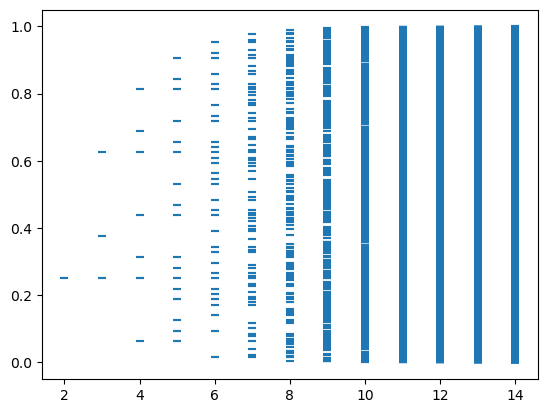

In [158]:
import matplotlib.pyplot as plt
import numpy as np

# Create the scatter plot
plt.scatter(parity_x, parity_y, marker='_')

plt.show()

In [160]:
parity_2 = sorted([label for label in set(PARITY_FLIP_LABELS) if len(label) == 2])
print((len(parity_2), 2**2))
parity_2

(1, 4)


['01']

In [171]:
T_01 = mrTupFromPath("01")
T_01

((2, -1), [(0, -1)])

In [175]:
T_011 = F_1(T_01)
T_011, mrTupValue(T_011)

(((3, -1), [(0, -1)]), (7, 3))

In [176]:
T_010 = F_0(T_01)
T_010, mrTupValue(T_010)

(((3, -2), [(0, -1), (2, -2)]), (1, 9))

In [161]:
parity_3 = sorted([label for label in set(PARITY_FLIP_LABELS) if len(label) == 3])
print((len(parity_3), 2**3))
parity_3

(3, 8)


['010', '011', '101']

In [162]:
parity_4 = sorted([label for label in set(PARITY_FLIP_LABELS) if len(label) == 4])
print((len(parity_4), 2**4))
parity_4

(7, 16)


['0001', '0100', '0101', '0111', '1010', '1011', '1101']

In [163]:
parity_5 = sorted([label for label in set(PARITY_FLIP_LABELS) if len(label) == 5])
print((len(parity_5), 2**5))
parity_5

(17, 32)


['00010',
 '00011',
 '00100',
 '00110',
 '00111',
 '01000',
 '01001',
 '01010',
 '01110',
 '01111',
 '10001',
 '10100',
 '10101',
 '10111',
 '11010',
 '11011',
 '11101']

In [164]:
parity_6 = sorted([label for label in set(PARITY_FLIP_LABELS) if len(label) == 6])
print((len(parity_6), 2**6))
parity_6

(33, 64)


['000001',
 '000110',
 '001001',
 '001011',
 '001100',
 '001101',
 '001110',
 '010000',
 '010001',
 '010011',
 '010101',
 '010110',
 '011001',
 '011100',
 '011101',
 '011111',
 '100010',
 '100011',
 '100100',
 '100110',
 '100111',
 '101000',
 '101001',
 '101010',
 '101110',
 '101111',
 '110001',
 '110100',
 '110101',
 '110111',
 '111010',
 '111011',
 '111101']

In [165]:
parity_7 = sorted([label for label in set(PARITY_FLIP_LABELS) if len(label) == 7])
print((len(parity_7), 2**7))
parity_7

(67, 128)


['0000010',
 '0000011',
 '0000101',
 '0001000',
 '0001010',
 '0001011',
 '0001101',
 '0001111',
 '0010110',
 '0010111',
 '0011000',
 '0011001',
 '0011011',
 '0011101',
 '0011110',
 '0100000',
 '0100001',
 '0100010',
 '0100100',
 '0100101',
 '0101010',
 '0101011',
 '0101100',
 '0101111',
 '0110010',
 '0110011',
 '0110100',
 '0110110',
 '0110111',
 '0111000',
 '0111001',
 '0111010',
 '0111110',
 '0111111',
 '1000001',
 '1000110',
 '1001001',
 '1001011',
 '1001100',
 '1001101',
 '1001110',
 '1010000',
 '1010001',
 '1010011',
 '1010101',
 '1010110',
 '1011001',
 '1011100',
 '1011101',
 '1011111',
 '1100010',
 '1100011',
 '1100100',
 '1100110',
 '1100111',
 '1101000',
 '1101001',
 '1101010',
 '1101110',
 '1101111',
 '1110001',
 '1110100',
 '1110101',
 '1110111',
 '1111010',
 '1111011',
 '1111101']

In [166]:
parity_14 = sorted([label for label in set(PARITY_FLIP_LABELS) if len(label) == 14])
print((len(parity_14), 2**14))


(8217, 16384)


In [167]:
16384//2 - 8217

-25

In [168]:
# The trend is a slightly larger fraction of the generation's nodes each time
#  ... but the movement away from 50:50 seems to be much slower than the exponential growth of the lattice generations


In [169]:
mrTupValue(mrTupFromPath("01"))

(1, 1)

In [183]:
n = 27
n_p2 = math.ceil(math.log(27, 2))
print(n_p2)
# Worst case every bit of number somehow encodes a 27n + 19 number
wc = 27
for i in range(27):
    wc = 27*wc + 19
wc

5


12296557616278085851257230141400272027344

In [182]:
2**70

1180591620717411303424